In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [2]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [5]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df.head()

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055,0.0008,3.174603e-08
1,2014-01-03,30.035,0.0008,3.174603e-08
2,2014-01-06,30.160,0.0008,3.174603e-08
3,2014-01-07,30.260,0.0007,2.777778e-08
4,2014-01-08,30.150,0.0007,2.777778e-08


In [6]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

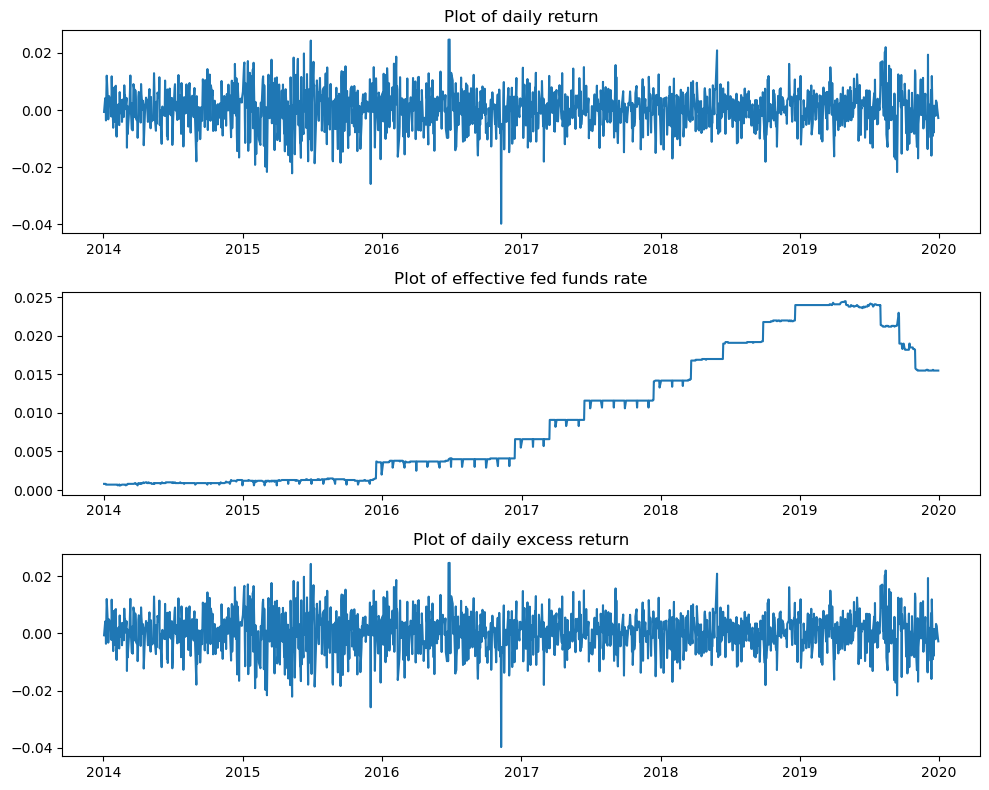

In [7]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[0].set_title('Plot of daily return')
ax[1].plot(df['Date'], df['EFFR'])
ax[1].set_title('Plot of effective fed funds rate')
ax[2].plot(df['Date'], df['Daily_excess_return'])
ax[2].set_title('Plot of daily excess return')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: LSTM Strategy

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_73459/2557935867.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


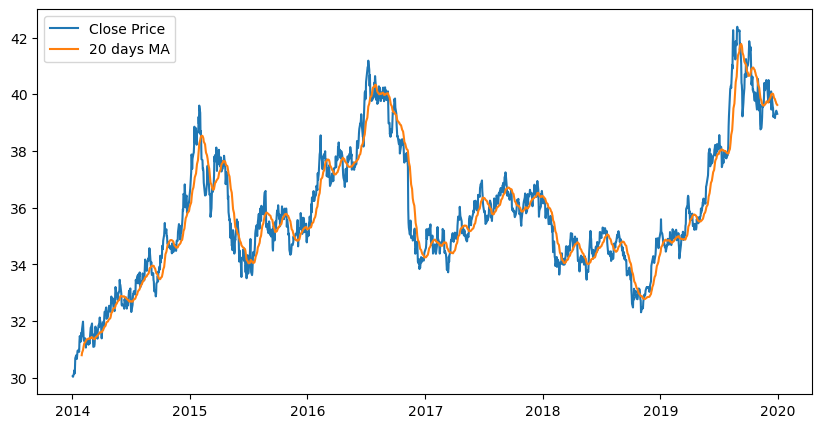

In [8]:
MA = 20
df['MA'] = df['Close'].rolling(MA).mean()
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(df['Date'], df['Close'], label = 'Close Price')
ax.plot(df['Date'], df['MA'], label = f'{MA} days MA')
plt.legend()
fig.show()


In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
data = df.copy()
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=50)
# data['EMAS']=ta.ema(data.Close, length=150)

# data['Target'] = data['Close']-data.Open
# data['Target'] = data['Target'].shift(-1)

# data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
dataset = data[['Close', 'RSI', 'EMAF', 'EMAM']]

In [11]:
dataset.head()

,Close,RSI,EMAF,EMAM
0,31.805000,60.627831,31.428095,31.179300
1,31.590000,54.966265,31.443515,31.195406
2,31.665001,56.485040,31.464609,31.213822
3,31.440001,50.960802,31.462265,31.222691
4,31.379999,49.575492,31.454430,31.228860


In [19]:
# Create a function to create a dataset with 60 timesteps
def create_dataset(dataset, time_step=60, y_colume_index=0):
    X, Y = [], []
    if not isinstance(dataset, np.ndarray):
        dataset = np.array(dataset).reshape(len(dataset), -1)

    if len(dataset.shape) == 1:
        dataset = dataset.reshape(-1, 1)
        
    # If we have 5 days of data and we want to look back 2 days
    # x1 = [d1, d2], y1 = [d3];
    # x2 = [d2, d3], y2 = [d4]; 
    # x3 = [d3, d4], y3 = [d5];
    for i in range(len(dataset) - time_step):
        
        # Slice from index i to index i + timestep, excluding (i + time_step)
        X.append(dataset[i:(i+time_step), :])
        Y.append(dataset[i + time_step, y_colume_index])
    return np.array(X), np.array(Y)


scalar = MinMaxScaler()
scaled_dataset = scalar.fit_transform(dataset)
# Create the dataset
time_step = 6
X, y = create_dataset(dataset, time_step)

# The shape should be, (number of sequence, number of days to look back, number of columns)
print(X.shape)
print(y.shape)



(1453, 6, 4)
(1453,)


In [20]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1162, 6, 4)
(291, 6, 4)
(1162,)
(291,)


In [23]:

#tf.random.set_seed(20)
np.random.seed(10)

# lstm_input = Input(shape=(time_step, X_train.shape[-1]), name='lstm_input')
# inputs = LSTM(150, name='first_layer')(lstm_input)
# inputs = Dense(1, name='dense_layer')(inputs)
# output = Activation('linear', name='output')(inputs)
# model = Model(inputs=lstm_input, outputs=output)
# adam = optimizers.Adam()
# model.compile(optimizer=adam, loss='mse')


# Build the LSTM model
model = Sequential()
# Return sequence: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
# Inputs: A 3D tensor, with shape (batch, timesteps, feature).
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30


2024-03-10 20:30:17.193079: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-10 20:30:19.620771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-10 20:30:19.854097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-10 20:30:20.214532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-10 20:30:20.474681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-10 20:30:20.696423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 474.0337

2024-03-10 20:30:23.043540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-10 20:30:23.128921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-10 20:30:23.202456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 6s 39ms/step - loss: 474.0337 - val_loss: 2.2660
Epoch 2/30
70/70 [==============================] - 1s 20ms/step - loss: 4.2471 - val_loss: 2.6451
Epoch 3/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5769 - val_loss: 2.9013
Epoch 4/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5661 - val_loss: 2.7435
Epoch 5/30
70/70 [==============================] - 1s 20ms/step - loss: 3.5774 - val_loss: 2.6286
Epoch 6/30
70/70 [==============================] - 1s 19ms/step - loss: 3.5693 - val_loss: 2.8114
Epoch 7/30
70/70 [==============================] - 1s 21ms/step - loss: 3.5807 - val_loss: 2.5348
Epoch 8/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5734 - val_loss: 2.5146
Epoch 9/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5915 - val_loss: 2.7390
Epoch 10/30
70/70 [==============================] - 1s 21ms/step - loss: 3.5572 - val_loss: 3.4210
Epoch 11/30
70/70 

In [39]:
y_pred_test = model.predict(X_test)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print(f"Root Mean Squared Error: {rmse}")

10/10 [==============================] - 0s 20ms/step
Root Mean Squared Error: 3.6601734317083277


In [36]:
y_pred_train = model.predict(X_train)
rmse = np.sqrt(np.mean((y_pred_train - y_train)**2))
print(f"Root Mean Squared Error: {rmse}")

37/37 [==============================] - 1s 10ms/step
Root Mean Squared Error: 2.5832463888841657


In [34]:
data

,index,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,RSI,EMAF,EMAM,TargetNextClose
0,49,2014-03-14,31.805000,0.0008,3.174603e-08,0.000315,0.000314,0.003145,31.43325,60.627831,31.428095,31.179300,31.590000
1,50,2014-03-17,31.590000,0.0008,3.174603e-08,-0.006760,-0.006760,-0.067600,31.45150,54.966265,31.443515,31.195406,31.665001
2,51,2014-03-18,31.665001,0.0008,3.174603e-08,0.002374,0.002374,0.023742,31.46800,56.485040,31.464609,31.213822,31.440001
3,52,2014-03-19,31.440001,0.0008,3.174603e-08,-0.007106,-0.007106,-0.071057,31.47975,50.960802,31.462265,31.222691,31.379999
4,53,2014-03-20,31.379999,0.0008,3.174603e-08,-0.001908,-0.001908,-0.019085,31.49050,49.575492,31.454430,31.228860,31.665001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1503,2019-12-20,39.240002,0.0155,6.150794e-07,-0.000509,-0.000510,-0.005100,39.87350,42.415528,39.692102,39.883412,39.160000
1455,1504,2019-12-23,39.160000,0.0155,6.150794e-07,-0.002039,-0.002039,-0.020394,39.82450,41.467326,39.641425,39.855043,39.290001
1456,1505,2019-12-24,39.290001,0.0155,6.150794e-07,0.003320,0.003319,0.033191,39.77550,43.660141,39.607956,39.832885,39.389999
1457,1506,2019-12-26,39.389999,0.0155,6.150794e-07,0.002545,0.002545,0.025445,39.72000,45.347559,39.587199,39.815516,39.419998


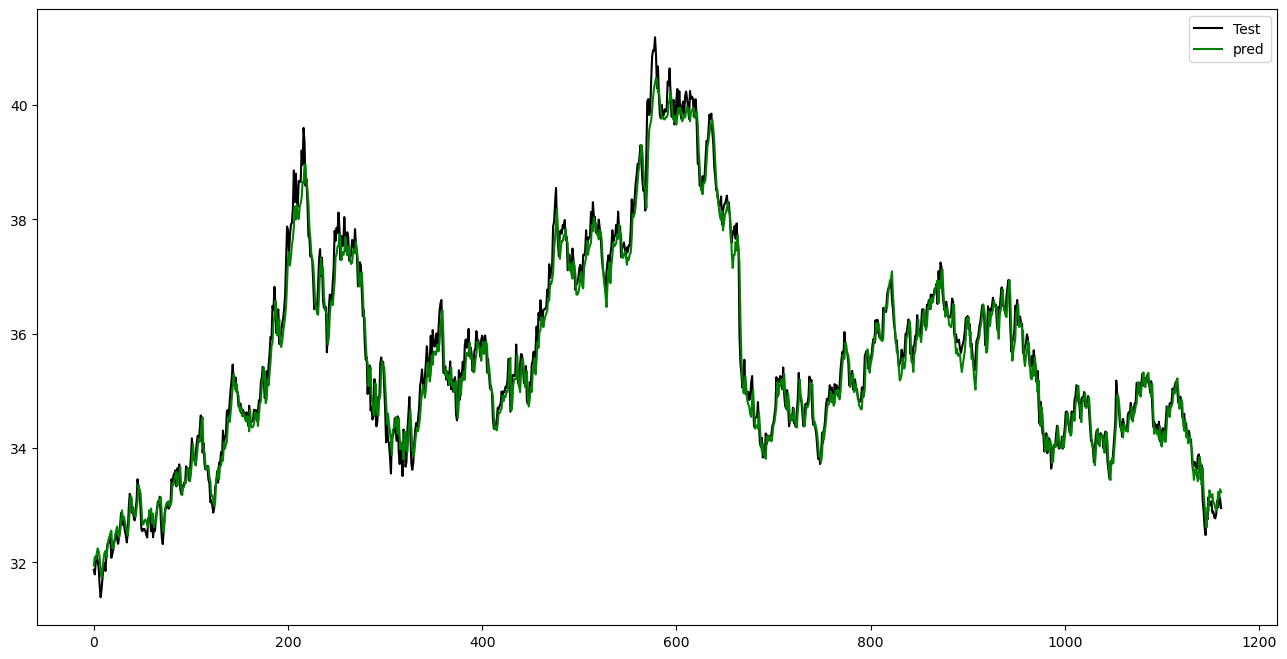

In [70]:
plt.figure(figsize=(16,8))
plt.plot(y_train, color = 'black', label = 'Test')
plt.plot(y_pred_train, color = 'green', label = 'pred')
plt.legend()
plt.show()

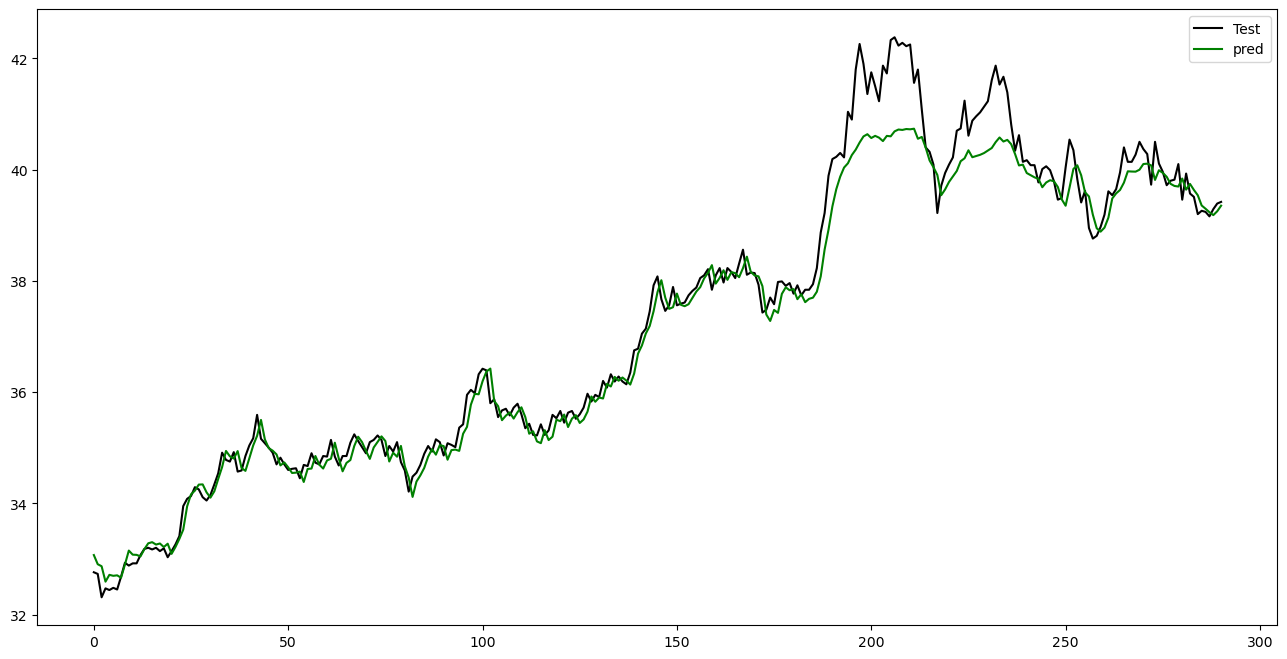

In [69]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred_test, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [82]:
def buy_sell_threshold(current_price, predicted_price, threshold):
    Buy, Sell = [np.nan], [np.nan]

    for i in range(len(predicted_price) - 1):
        if predicted_price[i] / current_price[i] - 1 > threshold:
            Buy.append(current_price[i])
            Sell.append(np.nan)
        elif predicted_price[i] / current_price[i] - 1 < -threshold:
            Sell.append(current_price[i])
            Buy.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
    return Buy, Sell

def generate_dynamic_signals(current_price, predictions, threshold=0.01):
    # Assuming predictions are normalized and centered around 0
    signals = np.zeros(len(predictions))

    for i in range(1, len(predictions)):
        change_percent = (predictions[i] / current_price[i] * 100) -1

        if abs(change_percent) > threshold:
            # Signal strength is proportional to the change percent
            signals[i] = np.tanh(change_percent)
        else:
            signals[i] = 0
    
    return signals


In [54]:
strategy_data = pd.DataFrame(index=data.index)
strategy_data['Close'] = data['Close']
strategy_data['Date'] = data['Date']
strategy_data['Predictions'] = np.nan
strategy_data['Daily_EFFR'] = data['Daily_EFFR']
strategy_data['Daily_excess_return'] = df['Daily_excess_return'] 

strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()

strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return
0,31.805000,2014-03-14,NaN,3.174603e-08,NaN
1,31.590000,2014-03-17,NaN,3.174603e-08,-0.000665
2,31.665001,2014-03-18,NaN,3.174603e-08,0.004162
3,31.440001,2014-03-19,NaN,3.174603e-08,0.003316
4,31.379999,2014-03-20,NaN,3.174603e-08,-0.003635
...,...,...,...,...,...
1454,39.240002,2019-12-20,39.296696,6.150794e-07,-0.011518
1455,39.160000,2019-12-23,39.233681,6.150794e-07,0.006940
1456,39.290001,2019-12-24,39.182148,6.150794e-07,-0.011818
1457,39.389999,2019-12-26,39.251488,6.150794e-07,0.000747


In [80]:
strategy_data['Expected_return'] = strategy_data['Predictions']/strategy_data['Close']-1
strategy_data

np.tanh(strategy_data['Expected_return']*100)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1454    0.894660
1455    0.954628
1456   -0.991779
1457   -0.998237
1458   -0.938524
Name: Expected_return, Length: 1459, dtype: float64

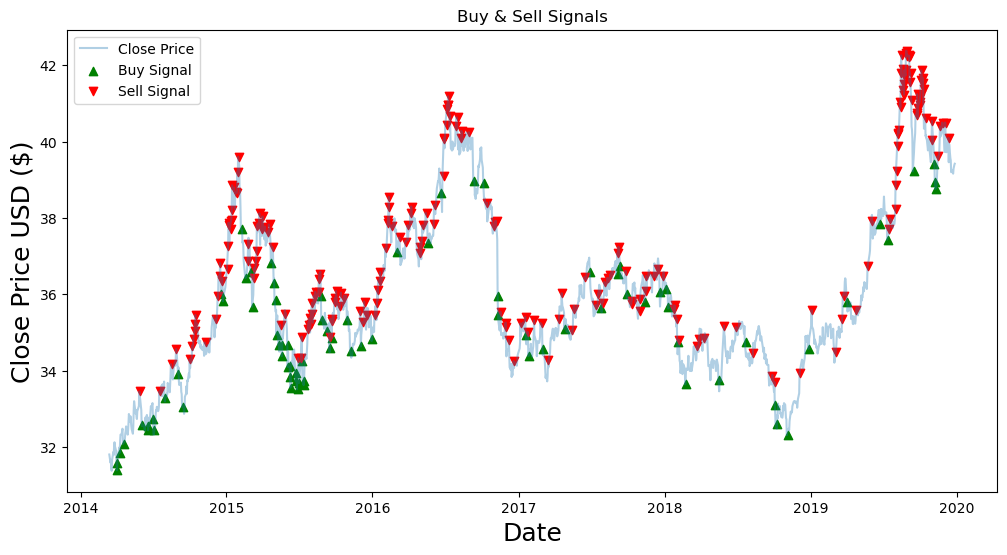

In [64]:

strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(strategy_data['Close'], strategy_data['Predictions'], 0.01)

# Plot the buy and sell signals on top of the closing price
plt.figure(figsize=(12,6))
plt.plot(strategy_data['Date'], strategy_data['Close'], label='Close Price', alpha=0.35)
# plt.plot(strategy_data['Date'], strategy_data['Predictions'], label='Close Price Prediction', alpha=0.35)
plt.scatter(strategy_data['Date'], strategy_data['Buy_Signal_Price'], label='Buy Signal', marker='^', alpha=1, color='green')
plt.scatter(strategy_data['Date'], strategy_data['Sell_Signal_Price'], label='Sell Signal', marker='v', alpha=1, color='red')
plt.title('Buy & Sell Signals')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='upper left')

In [83]:
buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
signal = buy_signal + sell_signal
strategy_data['Signal'] = generate_dynamic_signals(strategy_data['Close'], strategy_data['Predictions'])
strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return,Buy_Signal_Price,Sell_Signal_Price,Signal,Expected_return
0,31.805000,2014-03-14,NaN,3.174603e-08,NaN,NaN,NaN,0.0,NaN
1,31.590000,2014-03-17,NaN,3.174603e-08,-0.000665,NaN,NaN,0.0,NaN
2,31.665001,2014-03-18,NaN,3.174603e-08,0.004162,NaN,NaN,0.0,NaN
3,31.440001,2014-03-19,NaN,3.174603e-08,0.003316,NaN,NaN,0.0,NaN
4,31.379999,2014-03-20,NaN,3.174603e-08,-0.003635,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...
1454,39.240002,2019-12-20,39.296696,6.150794e-07,-0.011518,NaN,NaN,1.0,0.001445
1455,39.160000,2019-12-23,39.233681,6.150794e-07,0.006940,NaN,NaN,1.0,0.001882
1456,39.290001,2019-12-24,39.182148,6.150794e-07,-0.011818,NaN,NaN,1.0,-0.002745
1457,39.389999,2019-12-26,39.251488,6.150794e-07,0.000747,NaN,NaN,1.0,-0.003516


In [87]:
result = compute_position_value(df = strategy_data, signal = strategy_data['Signal'], initial_capital = 200000, leverage = 1)

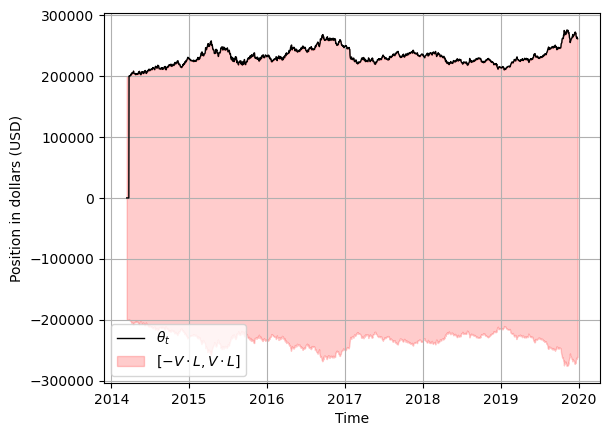

In [90]:
plot_position(strategy_data['Date'], result['theta'], result['V'], 1)

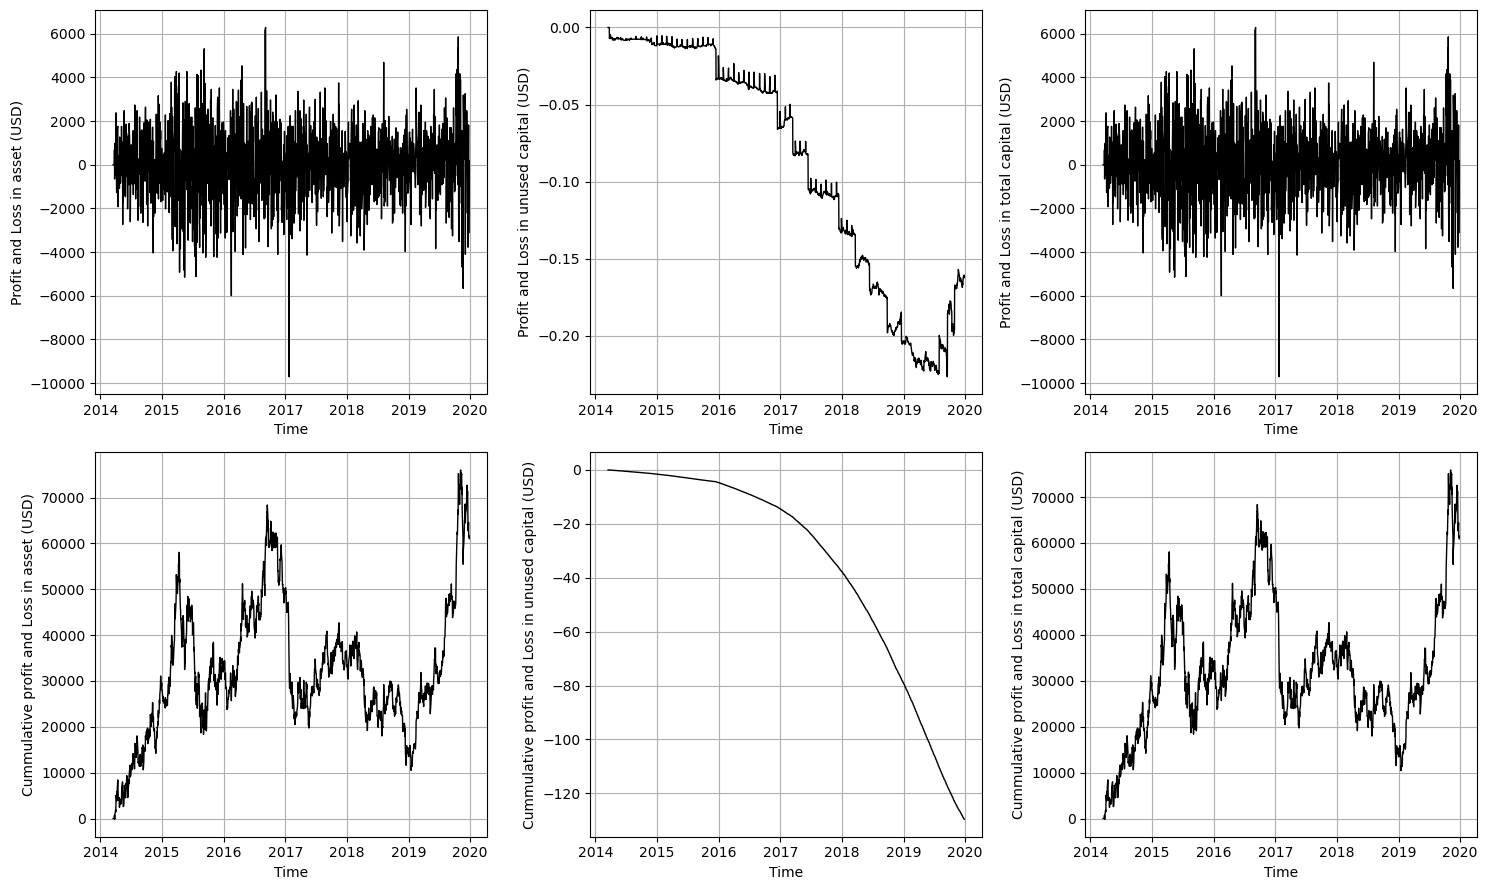

In [91]:
plot_PnL(strategy_data['Date'], result['V'], result['Vcap'], result['Vtot'])